# Mixed formulation for the general Poisson equation

This example is an alternative implementation of the *general Poisson equation* example (<a href="poisson_general.ipynb" target="_blank">Jupyter notebook</a>, <a href="poisson_general.html" target="_blank">HTML</a>) and is implemented in the Python file <a href="poisson_minimization.py" target="_blank">poisson_minimization.py</a>. It illustrates how to:

- Solve coupled partial differential equations using `MixedElement`;
- Split the (test)function into (test)functions that correspond to subspaces of the mixed element function space;
- Impose Dirichlet boundary conditions on a subspace of the function space.

## Equation and problem definition

The mixed formulation of the general Poisson equation on a unit disk ($R=1$) with the Dirichlet boundary condition on $\Gamma_D$ and the Neumann boundary condition on $\Gamma_N$:

<div align="center">    
    $\begin{array}{r c c l}
    \nabla \cdot {\boldsymbol \sigma}  &=& -f & \text{in } \Omega,\\
    {\boldsymbol \sigma} &=& a \nabla u & \text{in } \Omega,\\
    u &=& u_D & \text{on } \Gamma_D,\\
    {\bf n} \cdot {\boldsymbol \sigma} &=& g & \text{on } \Gamma_N,\\
    \end{array}$    
</div>
where $\bf n$ is the unit normal vector to the boundary and we introduced functions
<div align="center">    
    $\begin{array}{r c l}
    a &=& 1-\frac{1}{2} (x^2 + y^2),\\
    f &=& 1,\\
    u_D &=& x,\\
    g &=& y.\\
    \end{array}$    
</div>
&emsp;
<div align="center">    
    <img src="figs/poisson_general_domain.png" style="width: 250px;"/>
</div>

### Weak formulation of the problem

In FEniCS, we are solving the weak form of coupled PDEs
<div align="center">    
    $\begin{array}{l l}
    \int_\Omega d{\bf x} \ (-\nabla \cdot {\boldsymbol \sigma} -f) v = 0 & \text{in } \Omega,\\
    \int_\Omega d{\bf x} \ ({\boldsymbol \sigma} - a \nabla u) \cdot {\boldsymbol \tau}=0  & \text{in } \Omega,\\
    \end{array}$    
</div>

where $v$ and ${\boldsymbol \tau}$ are arbitrary *test functions*. Here, we assume that the boundary condition $u = u_D$ on $\Gamma_D$ is the *essential condition* and that the boundary condition ${\bf n} \cdot {\boldsymbol \sigma} = g$ on $\Gamma_N$ is the *natural condition*, which can be extracted from the weak form. Thus we impose the restriction $v=0$ on $\Gamma_D$, but there is no such restriction on ${\boldsymbol \tau}$. Using integration by parts, the first equation can be rewritten as 
$$\int_\Omega d{\bf x} \ ({\boldsymbol \sigma} \cdot \nabla v -  fv) - \oint_\Gamma ds \ ({\bf n} \cdot {\boldsymbol \sigma} v  = \int_\Omega d{\bf x} \ ({\boldsymbol \sigma} \cdot \nabla v -  fv) - \oint_\Gamma ds \ g v = 0,$$
where we can integrate over the entire boundary $\Gamma = \Gamma_D \bigcup \Gamma_N$, because $v=0$ on $\Gamma_D$.

<div class="alert alert-block alert-info">
Note that it is possible to switch the essentatial and natural boundary conditions, which is discussed in the <a href="https://fenicsproject.org/docs/dolfin/1.6.0/python/demo/documented/mixed-poisson/python/documentation.html" target="_blank">FEniCS demo</a>.
</div>

## Implementation

We import relevant libraries and generate mesh as was done in the *basic Poisson equation* example (<a href="poisson_basic.ipynb" target="_blank">Jupyter notebook</a>, <a href="poisson_basic.html" target="_blank">HTML</a>).

In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# Create mesh
R = 1. # radius
N = 20 # mesh density
domain = Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
#plot(mesh,linewidth=0.3)

We use `MixedElement` to define the combined function space for both $u$ (scalar) and ${\boldsymbol \sigma}$ (vector). First we define `FiniteElement`s that will be used (linear  Lagrange elements). Because ${\boldsymbol \sigma}$ is a 2D vector field we create a tensor product of finite elements.

In [2]:
#define function space with mixed finite elements
degreeElements = 1
FE_u     = FiniteElement('Lagrange', mesh.ufl_cell(), degreeElements)
FE_sigma = FiniteElement('Lagrange', mesh.ufl_cell(), degreeElements)
FS = FunctionSpace(mesh, MixedElement([FE_u, FE_sigma*FE_sigma]))

The (test)functions on this `FunctionSpace` can be defined as usual. However, it is convenient to `split` these (test)functions into (test)functions that correspond to subspaces.

In [3]:
# define function and split it into u and sigma
F  = Function(FS) 
u,sigma = split(F)

# define test function and split it into v and tau
TF = TestFunction(FS)
v,tau = split(TF)

The functions $a$, $f$, and $g$ are implemented in the same way as was done in the *general Poisson equation* example (<a href="poisson_general.ipynb" target="_blank">Jupyter notebook</a>, <a href="poisson_general.html" target="_blank">HTML</a>).

In [4]:
# define functions a and f
a  = Expression('1-0.5*(x[0]*x[0]+x[1]*x[1])', degree=degreeElements)
f  = 1

# define function g
class G(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval_cell(self, value, x, ufc_cell):
        value[0]=x[1]
    def value_shape(self):
        return ()

g  = G(degree=degreeElements)

The Dirichlet boundary condition $u=u_D=x$ on $\Gamma_D$ has to be imposed only on the subspace of the entire function space, which can be achieved with `.sub(0)`

In [5]:
#impose Dirichlet boundary conditions for u
def right_boundary(x, on_boundary):
    return on_boundary and x[0]>=0

uD = Expression('x[0]',degree=degreeElements)
bc = DirichletBC(FS.sub(0), uD, right_boundary)

Next, we write and solve the weak form of the problem. 

In [6]:
#weak formulation of the problem
Res_1 = (dot(sigma,grad(v)) - f*v)*dx - v*g*ds
Res_2 = (dot(sigma, tau) - dot(a*grad(u), tau))*dx
Res   = Res_1 + Res_2

# solve the problem and store solution in F
solve(Res == 0, F, bc)

The problem solution is stored in function `F`, which was split into functions `u` and `sigma`. These functions can be accessed directly to plot the values of functions $u$ and $\boldsymbol \sigma$.

To calculate the function ${\boldsymbol \sigma}=a \nabla u$, we *project* the expression `a*grad(u)` on the `VectorFunctionSpace`.

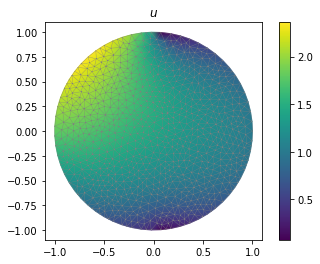

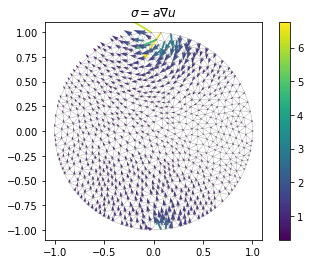

In [7]:
# plot solution for u
c = plot(u,mode='color',title='$u$')
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

# plot solution for sigma
c=plot(sigma,title='$\sigma=a \\nabla u$',width=.008)
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

To calculate the function
$\nabla \cdot {\boldsymbol \sigma}=\nabla \cdot (a \nabla u)$, we project the expression `div(sigma)` on the FunctionSpace `FS`.

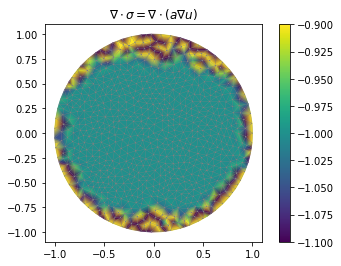

In [8]:
# plot solution for div(sigma)=div(a*grad(u))
V = FunctionSpace(mesh, 'Lagrange', degreeElements)
divSigma = project(div(sigma), V)
c=plot(divSigma,mode='color',title='$\\nabla \cdot \sigma=\\nabla \cdot (a \\nabla u)$',vmin=-1.1,vmax=-0.9)
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

Note that the function $\nabla \cdot {\boldsymbol \sigma}=\nabla \cdot (a \nabla u)$  should evaluate to $\nabla \cdot (a \nabla u)=-f=-1$. The results are accurate in the bulk, but they deviate in a narrow boundary layer.

## Complete code

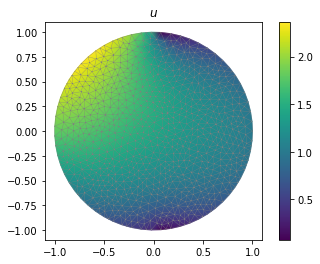

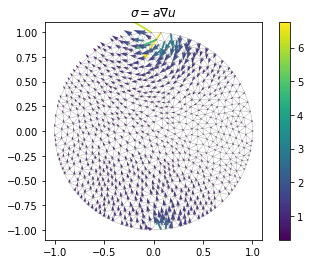

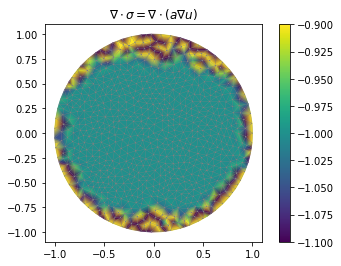

In [9]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

# Create mesh
R = 1. # radius
N = 20 # mesh density
domain = Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
#plot(mesh,linewidth=0.3)


#define function space with mixed finite elements
degreeElements = 1
FE_u     = FiniteElement('Lagrange', mesh.ufl_cell(), degreeElements)
FE_sigma = FiniteElement('Lagrange', mesh.ufl_cell(), degreeElements)
FS = FunctionSpace(mesh, MixedElement([FE_u, FE_sigma*FE_sigma]))

# define function and split it into u and sigma
F  = Function(FS) 
u,sigma = split(F)

# define test function and split it into v and tau
TF = TestFunction(FS)
v,tau = split(TF)


# define functions a and f
a  = Expression('1-0.5*(x[0]*x[0]+x[1]*x[1])', degree=degreeElements)
f  = 1

# define function g
class G(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval_cell(self, value, x, ufc_cell):
        value[0]=x[1]
    def value_shape(self):
        return ()
    
g  = G(degree=degreeElements)


#impose Dirichlet boundary conditions for u
def right_boundary(x, on_boundary):
    return on_boundary and x[0]>=0

uD = Expression('x[0]',degree=degreeElements)
bc = DirichletBC(FS.sub(0), uD, right_boundary)

#weak formulation of the problem
Res_1 = (dot(sigma,grad(v)) - f*v)*dx - v*g*ds
Res_2 = (dot(sigma, tau) - dot(a*grad(u), tau))*dx
Res   = Res_1 + Res_2

# solve the problem and store solution in F
solve(Res == 0, F, bc)

# plot solution for u
c = plot(u,mode='color',title='$u$')
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

# plot solution for sigma
c=plot(sigma,title='$\sigma=a \\nabla u$',width=.008)
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()

# plot solution for div(sigma)=div(a*grad(u))
V = FunctionSpace(mesh, 'Lagrange', degreeElements)
divSigma = project(div(sigma), V)
c=plot(divSigma,mode='color',title='$\\nabla \cdot \sigma=\\nabla \cdot (a \\nabla u)$',vmin=-1.1,vmax=-0.9)
plt.colorbar(c)
plot(mesh,linewidth=0.3)
plt.show()